# Instrumental Variables

The example and data is taken from [Non Compliance and LATE](https://matheusfacure.github.io/python-causality-handbook/09-Non-Compliance-and-LATE.html). Consider a scenario where you aim to increase user engagement by boosting in-app purchases. Your marketing team designs a fancy push notification campaign, and you conduct an experiment where 10,000 customers are randomly assigned to either receive the push or not. However, you find that some customers assigned to receive the push don't actually get it due to technical issues, such as having older phones that don't support the notification.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pyfixest as pf

%config InlineBackend.figure_format = "retina"

## Context

At first, it seems like you could simply analyze the impact by focusing on those who actually received the push. However, this introduces bias because users with older phones are less likely to receive the notification, which may be correlated with their income and affect in-app purchases. 

Since income is an unobserved variable, using treatment received leads to selection bias (confounding). Similarly, using treatment assigned doesn’t capture the true effect because non-compliance dilutes the treatment impact. To address this, instrumental variables come into play.

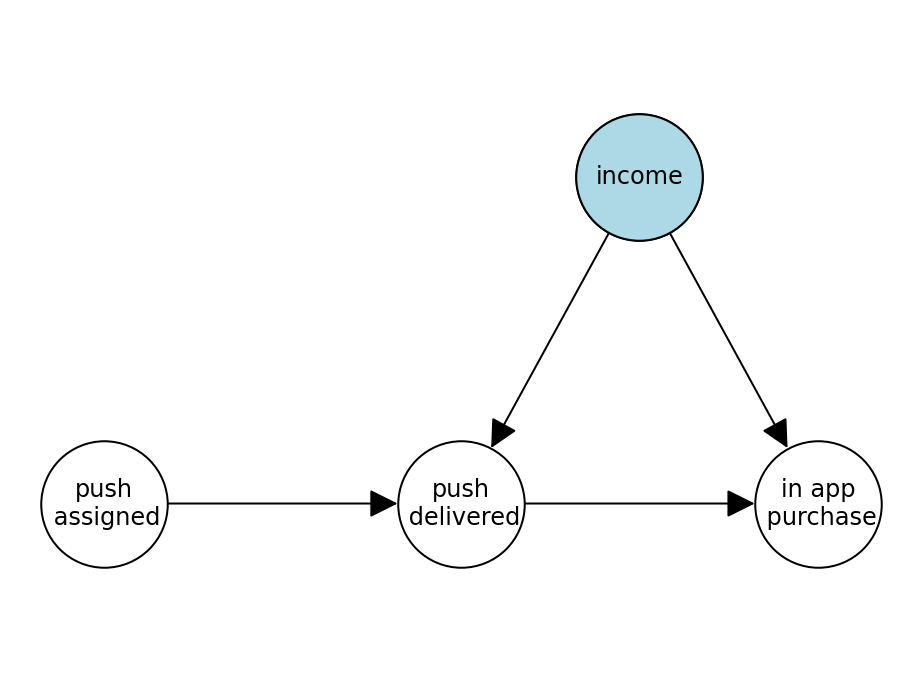

In [3]:
# Create a directed graph
G = nx.DiGraph()

# Add edges (nodes are created automatically)
G.add_edges_from([
    ("push\n assigned", "push\n delivered"),
    ("push\n delivered", "in app\n purchase"),
    ("income", "push\n delivered"),
    ("income", "in app\n purchase")
])

# Define node positions for a more visually appealing layout
pos = {
    "push\n assigned": (0, 0),
    "push\n delivered": (1, 0),
    "income": (1.5, 0.5),
    "in app\n purchase": (2, 0)
}

# Draw the nodes and edges
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, node_size=4000, node_color='white', edgecolors='black', node_shape='o')
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrows=True, arrowsize=30, node_size=4000)

# Draw labels for the nodes
nx.draw_networkx_labels(G, pos, font_size=12)

# Highlight the 'income' node in blue
nx.draw_networkx_nodes(G, pos, nodelist=["income"], node_size=4000, node_color='lightblue', edgecolors='black')

# Disable axis and limits
plt.axis('off')
plt.xlim(-0.25, 2.25)
plt.ylim(-0.25, 0.75)

# Show the plot
plt.show()

In [4]:
# Read data
path_data = "https://github.com/matheusfacure/python-causality-handbook/raw/master/causal-inference-for-the-brave-and-true/data/"
data = pd.read_csv(path_data + 'app_engagement_push.csv')
data['in_app_purchase'] = (data['in_app_purchase'] / 10).round(0).astype(int)  # transform to USD
data.tail()

,in_app_purchase,push_assigned,push_delivered
9995,5,0,0
9996,7,1,1
9997,4,0,0
9998,6,0,0
9999,7,0,0


In [5]:
data.describe().round(2)

,in_app_purchase,push_assigned,push_delivered
count,10000.00,10000.00,10000.00
mean,7.04,0.49,0.35
std,2.63,0.50,0.48
min,1.00,0.00,0.00
25%,5.00,0.00,0.00
50%,7.00,0.00,0.00
75%,9.00,1.00,1.00
max,22.00,1.00,1.00


## OLS

In [6]:
ols = pf.feols(fml='in_app_purchase ~ push_assigned + push_delivered', data=data)
ols.summary()

###

Estimation:  OLS
Dep. var.: in_app_purchase, Fixed effects: 
Inference:  iid
Observations:  10000

| Coefficient    |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:---------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept      |      6.925 |        0.035 |   199.124 |      0.000 |  6.857 |   6.993 |
| push_assigned  |     -1.741 |        0.075 |   -23.284 |      0.000 | -1.888 |  -1.594 |
| push_delivered |      2.763 |        0.078 |    35.362 |      0.000 |  2.610 |   2.916 |
---
RMSE: 2.473 R2: 0.113 


OLS estimates that the push notification increases in-app purchases by $2. However, this estimate is likely biased. Since older phones struggle to receive the push, wealthier customers with newer phones are more likely to comply. As a result, the estimate might be positively biased, meaning the true effect of the push is likely lower than $2.

## Two-Stage Least Squares (2SLS)

In [7]:
iv = pf.feols(fml='in_app_purchase ~ 1 | push_delivered ~ push_assigned', data=data)
iv.summary()

###

Estimation:  IV
Dep. var.: in_app_purchase, Fixed effects: 
Inference:  iid
Observations:  10000

| Coefficient    |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:---------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept      |      6.925 |        0.036 |   190.175 |      0.000 |  6.854 |   6.996 |
| push_delivered |      0.337 |        0.072 |     4.669 |      0.000 |  0.196 |   0.479 |
---



The 2SLS estimate is much lower than the OLS result, showing 30 cents compared to $2. This is expected, as the OLS estimate was likely biased upward.

In [8]:
pf.etable([iv._model_1st_stage, iv])

GT(_tbl_data=                                     (1)                    (2)     rowtype
0       Intercept    -0.000 <br> (0.004)  6.925*** <br> (0.036)        coef
1   push_assigned  0.718*** <br> (0.006)                               coef
2  push_delivered                         0.337*** <br> (0.072)        coef
3    Observations                  10000                  10000  modelstats
4       S.E. type                    iid                    iid  modelstats
5              R2                  0.562                      -  modelstats, _body=<great_tables._gt_data.Body object at 0x310d97250>, _boxhead=Boxhead([ColInfo(var='', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='left', column_width=None), ColInfo(var='(1)', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='(2)', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='rowtype', type=<ColInfoTypeEnum.row_group: 3>, column_label='rowtype', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x310a2b3a0>, _spanners=Spanners([SpannerInfo(spanner_id='Y', spanner_level=1, spanner_label='Y', spanner_units=None, spanner_pattern=None, vars=['(1)'], built=None), SpannerInfo(spanner_id='in_app_purchase', spanner_level=1, spanner_label='in_app_purchase', spanner_units=None, spanner_pattern=None, vars=['(2)'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x310fa64c0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='hidden'), table_border_bottom_width=OptionsInfo(scss=



Importantly, the 2SLS result represents the Local Average Treatment Effect (LATE), which captures the average causal effect on compliers—those with newer phones. Unfortunately, we cannot infer the effect on "never takers," or those with older phones, meaning the estimate mainly reflects the impact on the wealthier portion of the population.

In [9]:
print('Traditional First Stage F-statistic: {:.2f}'.format(iv._f_stat_1st_stage))
iv.IV_Diag()
print('Robust First Stage F-statistic: {:.2f}'.format(iv._eff_F))

Traditional First Stage F-statistic: 12846.41
Robust First Stage F-statistic: 12556.82


The F-Statistic of the first stage indicates the strength of the instrument. A rule of thumb is that an F-statistic below 10 suggests a weak instrument, which can lead to biased estimates. In this case, the F-statistic is above 10, indicating a strong instrument.

The robust F-Statisitic is also calculated to allow for errors that are not conditionally homoskedastic and serially uncorrelated.

https://blogs.worldbank.org/en/impactevaluations/weekly-links-october-4--2024--why-optimal-taxes-may-look-differe?CID=WBW_AL_BlogNotification_EN_EXT

## Weak IV

In [10]:
rng = np.random.default_rng(42)

n = 100
beta = 0.1  # 0.1 weak IV
# beta = 1  # 1 strong IV

# Simulate data
U = rng.normal(size=n)  # generate error term
Z = rng.normal(size=n)  # generate instrument
D = beta * Z + U        # generate endogenous variable
Y = D + U               # the true causal effect is 1

df = pd.DataFrame({'Y': Y, 'D': D, 'Z': Z})
df.sample(5)

,Y,D,Z
48,1.464425,0.785512,1.065980
21,-1.343932,-0.663002,0.179276
81,-1.301914,-0.639988,0.219383
8,0.050428,0.067230,0.840308
46,1.681648,0.810219,-0.612097


In [11]:
iv = pf.feols(fml='Y ~ 1 | D ~ Z', data=df)
pf.etable([iv._model_1st_stage, iv])

GT(_tbl_data=                                 (1)                    (2)     rowtype
0     Intercept  -0.049 <br> (0.078)    -0.028 <br> (0.046)        coef
1             Z  0.175* <br> (0.080)                               coef
2             D                       1.428*** <br> (0.261)        coef
3  Observations                  100                    100  modelstats
4     S.E. type                  iid                    iid  modelstats
5            R2                0.047                      -  modelstats, _body=<great_tables._gt_data.Body object at 0x3111117f0>, _boxhead=Boxhead([ColInfo(var='', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='left', column_width=None), ColInfo(var='(1)', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='(2)', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='rowtype', type=<ColInfoTypeEnum.row_group: 3>, column_label='rowtype', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x31110d970>, _spanners=Spanners([SpannerInfo(spanner_id='Y', spanner_level=1, spanner_label='Y', spanner_units=None, spanner_pattern=None, vars=['(1)', '(2)'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x31110d910>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='hidden'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInf

Note that the instrument is weak here (strength of the instrument is controlled by setting $\beta$) -- the t-stat is smaller than any rule-of-thumb suggested in the literature (e.g. $\sqrt{10}$) .

In [12]:
print('Traditional First Stage F-statistic: {:.2f}'.format(iv._f_stat_1st_stage))
iv.IV_Diag()
print('Robust First Stage F-statistic: {:.2f}'.format(iv._eff_F))

Traditional First Stage F-statistic: 4.81
Robust First Stage F-statistic: 5.24


In [15]:
# Run 10000 trials to evaluate distribution of the IV estimator

nsim = 10000  # trials
IVEst = np.zeros(nsim)

for i in range(nsim):
    U = rng.normal(size=n)
    Z = rng.normal(size=n)
    D = beta * Z + U
    Y = D + U
    df = pd.DataFrame({'Y': Y, 'D': D, 'Z': Z})

    # IV regression
    iv = pf.feols(fml='Y ~ 1 | D ~ Z', data=df)
    IVEst[i] = iv.coef()['D']

Rejection Frequency is 0.2301 while we expect it to be around 0.05


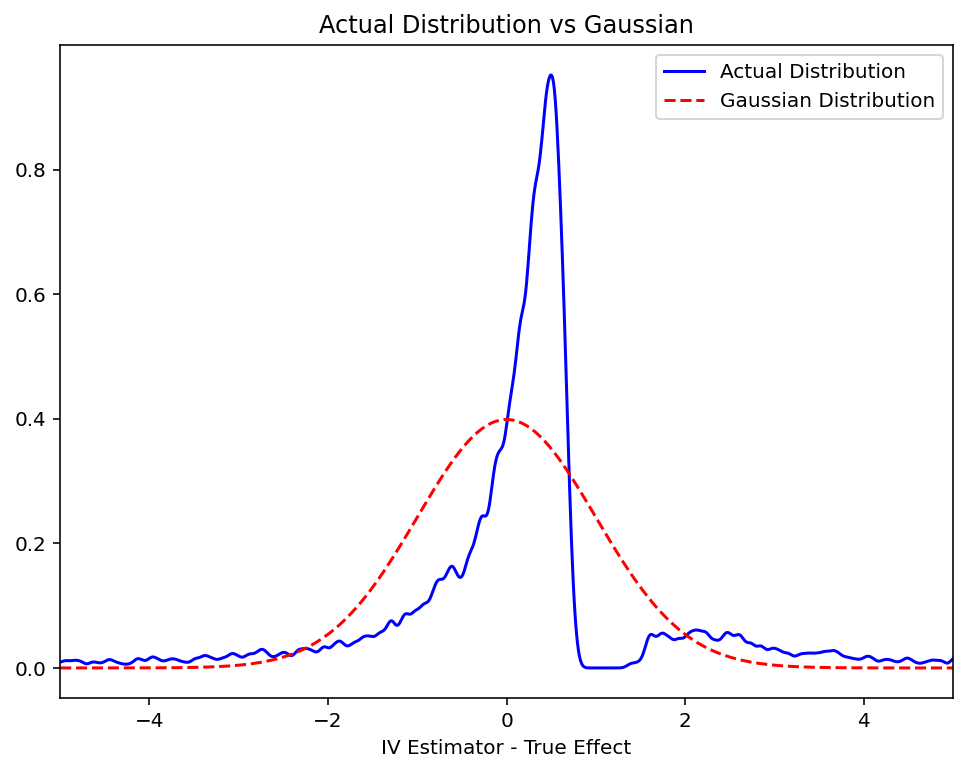

In [17]:
# Plot the Actual Distribution against the Normal Approximation (based on Strong Instrument Assumption)

import scipy.stats as stats

# Plotting the density of IVEst
plt.figure(figsize=(8, 6))
plt.xlim(-5, 5)
plt.xlabel("IV Estimator - True Effect")
plt.title("Actual Distribution vs Gaussian")

# Plotting density estimate of simulated IV coefficients
val = np.linspace(-5, 5, 200)
kde = stats.gaussian_kde(IVEst - 1, bw_method=.001)  # Need to play with bandwidth depending on problem features.
density = kde(np.linspace(-5, 5, 1000))
plt.plot(np.linspace(-5, 5, 1000), density, color='blue', label='Actual Distribution')

# Plotting Gaussian distribution
var = (1 / (beta ** 2)) * (1 / n)  # theoretical variance of IV
sd = np.sqrt(var)
gaussian = stats.norm.pdf(val, scale=sd)
plt.plot(val, gaussian, color='red', linestyle='--', label='Gaussian Distribution')

plt.legend()

# Calculating rejection frequency
rejection_frequency = np.sum(np.abs(IVEst - 1) / sd > 1.96) / nsim
print("Rejection Frequency is", rejection_frequency, "while we expect it to be around 0.05")

plt.show()